In [1]:
import json
all_reviews = sc.textFile("s3n://stat-37601/ratings.json",minPartitions=1000).map(json.loads)
reviews, reviews_test = all_reviews.randomSplit([.7, .3])
reviews.cache()
reviews_test.cache()

def getLabel(review):
    """
    Get the overall rating from a review
    """
    label, total = review["review_overall"].split("/")
    return float(label) / float(total)

labels = all_reviews.map(getLabel)
labels.cache()

PythonRDD[4] at RDD at PythonRDD.scala:42

In [2]:
STOPWORDS = ['a','able','about','across','after','all','almost','also','am','among',
'an','and','any','are','as','at','be','because','been','but','by','can',
'cannot','could','dear','did','do','does','either','else','ever','every',
'for','from','get','got','had','has','have','he','her','hers','him','his',
'how','however','i','if','in','into','is','it','its','just','least','let',
'like','likely','may','me','might','most','must','my','neither','no','nor',
'not','of','off','often','on','only','or','other','our','own','rather','said',
'say','says','she','should','since','so','some','than','that','the','their',
'them','then','there','these','they','this','tis','to','too','twas','us',
'wants','was','we','were','what','when','where','which','while','who',
'whom','why','will','with','would','yet','you','your','is']

In [3]:
import re
def clean(x):
    x1=re.sub("[^a-zA-Z]"," ", x).lower().split()
    x2=[t for t in x1 if t not in STOPWORDS]
    return x2

# a

Prepare data for regressions. Get rid of stop words and punctuations. Prepare data as RDD of labeledPoint.

In [4]:
import string
import unicodedata
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.feature import IDF
from pyspark.mllib.feature import Normalizer
from pyspark.mllib.regression import LabeledPoint
num_features=100
HashingTF = HashingTF(num_features)
def tfidf(x):
    idf = IDF().fit(x)
    tfidf = idf.transform(x)
    return tfidf

def prepare_data(dat):
    labels=dat.map(getLabel)
    review_txt=dat.map(lambda x: (x['beer_beerId'],x['review_text']))
    parsed_txt=review_txt.map(lambda x: (x[0],clean(x[1].encode('ascii','ignore').translate(string.maketrans("",""), string.punctuation))))
    hashes=parsed_txt.map(lambda x: (x[0],HashingTF.transform(x[1])))
    TFIDF=tfidf(hashes.map(lambda x: x[1]))
    normalizer1 = Normalizer()
    features=normalizer1.transform(TFIDF)
    data = features.zip(labels).map(lambda (feature, label): LabeledPoint(label, feature))
    return data

# b. MSE function

In [5]:
def mse(model,test,count_test):
    test_preds = (test.map(lambda p: p.label)).zip(model.predict(test.map(lambda p: p.features)))
    test_err = test_preds.map(lambda (v,p): (v-p)**2).reduce(lambda x,y: x + y) / count_test
    return test_err

prepare training and test data

In [6]:
train=prepare_data(reviews)
#train1=train.take(1)
test=prepare_data(reviews_test)
#test1=test.take(1)

In [7]:
train.cache()
test.cache()

PythonRDD[40] at RDD at PythonRDD.scala:42

# c. Implement Models

First, try out maxDepth for DecisionTree. And fit a model on full training data with selected maxDepth.

Split training data into training set and test set for parameter selection purpose. And for DecisionTree, we try maxDepth 1,3,5,7, and after that we hit memory issues. 

In [8]:
from pyspark.mllib.tree import DecisionTree, RandomForest, GradientBoostedTrees
train_cv,test_cv=train.randomSplit([.7, .3])
train_cv.cache()
test_cv.cache
test_cv_count=test_cv.count()    

In [9]:
def cv_tree(train,test,depth,test_count):
    tree=DecisionTree.trainRegressor(train,maxDepth=depth,categoricalFeaturesInfo={}, impurity='variance')
    test_err = mse(tree,test,test_count)
    return test_err

In [62]:
print train_cv_count,test_cv_count

1432722 614672


In [48]:
e1=cv_tree(train_cv,test_cv,1,test_cv_count)
e3=cv_tree(train_cv,test_cv,3,test_cv_count)
e5=cv_tree(train_cv,test_cv,5,test_cv_count)
e7=cv_tree(train_cv,test_cv,7,test_cv_count)

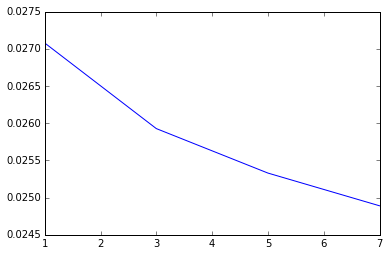

In [21]:
e_tree={1:0.0270781617330599,3:e3,5:0.025329872332751236,7:e7}
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(e_tree.keys(),e_tree.values())


Here, we see error goes down as maxDepth goes up. So we choose 7 as maxDepth for fitting on whole training data.

Next we select parameter maxDepth for RandomForest.

In [10]:
def cv_RF(train,test,depth,test_count):
    RF=RandomForest.trainRegressor(train, categoricalFeaturesInfo={},numTrees=10,maxDepth=depth)
    test_err = mse(RF,test,test_count)
    return test_err

In [17]:
e1_RF=cv_RF(train_cv,test_cv,1,test_cv_count)
e1_RF

0.0268934428342331

In [18]:
e5_RF=cv_RF(train_cv,test_cv,5,test_cv_count)
e5_RF

0.025073758400422863

In [11]:
e3_RF=cv_RF(train_cv,test_cv,3,test_cv_count)
e3_RF

0.025715361076379662

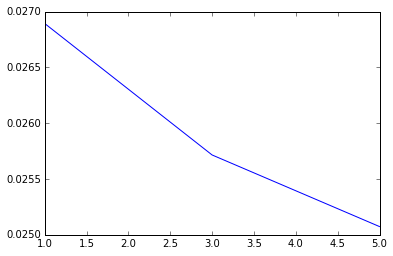

In [12]:
e_RF={1:0.0268934428342331,3:0.025715361076379662,5:0.025073758400422863}
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(e_RF.keys(),e_RF.values())

We hit memory issue when going above 5 using 10 trees in random forest. So we choose maxDepth=5 for randomForest model.

Finally we choose parameter for gradientBoosting.

We try to choose the best combination of maxDepth and learning rate

In [15]:
GB=GradientBoostedTrees.trainRegressor(train_cv, {},numIterations=100,maxDepth=1,learningRate=0.1)
e_GB_1=mse(GB,test_cv,test_cv_count)
e_GB_1

4.051607755183705

In [ ]:
GB=GradientBoostedTrees.trainRegressor(train_cv, {},numIterations=100,maxDepth=3,learningRate=0.1)
e_GB_3=mse(GB,test_cv,test_cv_count)
e_GB_3

0.023054038721120284

Here we see that using maxDepth 1 gives too much error. So we will not consider maxDepth 1. And go with maxDepth 3.

In [12]:
GB=GradientBoostedTrees.trainRegressor(train_cv, {},numIterations=100,maxDepth=3,learningRate=0.5)
e_GB_1_1=mse(GB,test_cv,test_cv_count)
e_GB_1_1

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job 513 cancelled because Stage 827 was cancelled
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1203)
	at org.apache.spark.scheduler.DAGScheduler.handleJobCancellation(DAGScheduler.scala:1173)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply$mcVI$sp(DAGScheduler.scala:1161)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleStageCancellation$1.apply(DAGScheduler.scala:1160)
	at scala.collection.IndexedSeqOptimized$class.foreach(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofInt.foreach(ArrayOps.scala:156)
	at org.apache.spark.scheduler.DAGScheduler.handleStageCancellation(DAGScheduler.scala:1160)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1366)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1354)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)


In [ ]:
GB=GradientBoostedTrees.trainRegressor(train_cv, {},numIterations=100,maxDepth=3,learningRate=0.3)
e_GB_3_2=mse(GB,test_cv,test_cv_count)
e_GB_3_2